#기존 코드

In [112]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [113]:
# 격자 환경 설정
class GridEnvironment:
    def __init__(self, n):
        self.n = n
        self.goal = (0, 0)
        self.max_steps = 2 * n
        self.reset()

    def reset(self):
        self.agent_pos = (np.random.randint(0, self.n), np.random.randint(0, self.n))
        self.steps = 0

    def step(self, action):
        self.steps += 1
        if action == 0:  # Up
            self.agent_pos = (max(0, self.agent_pos[0] - 1), self.agent_pos[1])
        elif action == 1:  # Down
            self.agent_pos = (min(self.n - 1, self.agent_pos[0] + 1), self.agent_pos[1])
        elif action == 2:  # Left
            self.agent_pos = (self.agent_pos[0], max(0, self.agent_pos[1] - 1))
        elif action == 3:  # Right
            self.agent_pos = (self.agent_pos[0], min(self.n - 1, self.agent_pos[1] + 1))

        if self.agent_pos == self.goal:
            reward = 1.0
            done = True
        else:
            reward = -0.1  # Penalty for each non-goal step
            done = self.steps >= self.max_steps

        return np.array(self.agent_pos), reward, done

In [114]:
# 정책 신경망
class PolicyNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return self.softmax(x)

In [115]:
# REINFORCE 알고리즘
def reinforce(env, policy_net, optimizer, num_episodes=1000):
    episode_rewards = []

    for episode in range(num_episodes):
        episode_reward = 0
        log_probs = []
        rewards = []

        state = torch.FloatTensor([env.agent_pos[0], env.agent_pos[1]])

        while True:
            action_probs = policy_net(state)
            action = torch.multinomial(action_probs, 1).item()
            log_probs.append(torch.log(action_probs[action]))

            next_state, reward, done = env.step(action)
            rewards.append(reward)
            episode_reward += reward

            if done:
                break

            state = torch.FloatTensor([next_state[0], next_state[1]])

        episode_rewards.append(episode_reward)

        # 정책 업데이트
        returns = []
        G = 0
        for r in rewards[::-1]:
            G = r + 0.9 * G
            returns.insert(0, G)

        policy_loss = []
        for log_prob, G in zip(log_probs, returns):
            policy_loss.append(-log_prob * G)
        policy_loss = torch.stack(policy_loss).sum()

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        env.reset()

    return episode_rewards

In [116]:
# 시각화 함수
def plot_rewards(episode_rewards):
    plt.plot(episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('REINFORCE Algorithm')
    plt.show()

In [117]:
# 최적의 정책을 결정하는 함수
def optimal_policy(env, policy_net):
    optimal_actions = np.zeros((env.n, env.n), dtype=int)
    for i in range(env.n):
        for j in range(env.n):
            state = torch.FloatTensor([i, j])
            action_probs = policy_net(state)
            optimal_actions[i, j] = torch.argmax(action_probs).item()
    return optimal_actions

# 최적의 경로를 시각화하는 함수
def plot_optimal_path(optimal_actions, n):
    actions_map = {0: 'v', 1: '^', 2: '<', 3: '>'}
    plt.figure(figsize=(6, 6))
    for i in range(n):
        for j in range(n):
            if (i, j) != (0, 0):
                plt.text(j, n-1-i, actions_map[optimal_actions[i, j]], ha='center', va='center', fontsize=12)
    plt.xlim(-0.5, n-0.5)
    plt.ylim(-0.5, n-0.5)
    plt.xticks(np.arange(-0.5, n, 1))
    plt.yticks(np.arange(-0.5, n, 1))
    plt.grid(True)
    plt.gca().invert_yaxis()
    plt.title('Optimal Policy')
    plt.show()

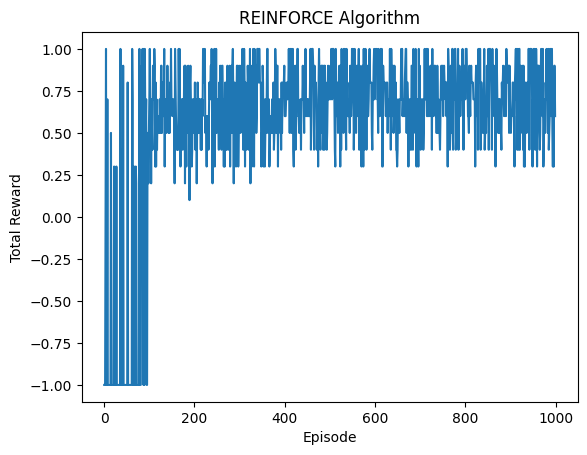

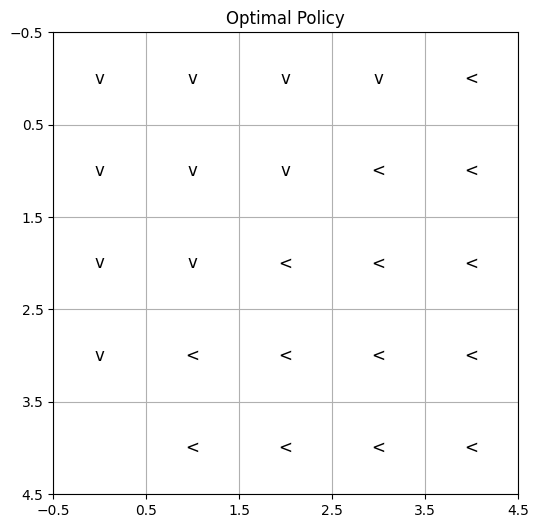

In [118]:
# 주어진 조건에 맞게 초기화
n = 5
env = GridEnvironment(n)
input_size = 2
hidden_size = 32
output_size = 4
policy_net = PolicyNetwork(input_size, hidden_size, output_size)
optimizer = optim.Adam(policy_net.parameters(), lr=0.01)

# REINFORCE 알고리즘 실행
episode_rewards1 = reinforce(env, policy_net, optimizer, num_episodes=1000)

# 최적의 정책 계산
optimal_actions1 = optimal_policy(env, policy_net)

# 시각화
plot_rewards(episode_rewards1)
plot_optimal_path(optimal_actions1, n)


# State value function

In [119]:
def reinforce_with_state_value(env, policy_net, value_net, policy_optimizer, value_optimizer, num_episodes=1000):
    episode_rewards = []

    for episode in range(num_episodes):
        episode_reward = 0
        log_probs = []
        rewards = []
        states = []

        state = torch.FloatTensor([env.agent_pos[0], env.agent_pos[1]])

        while True:
            states.append(state)
            action_probs = policy_net(state)
            action = torch.multinomial(action_probs, 1).item()
            log_probs.append(torch.log(action_probs[action]))

            next_state, reward, done = env.step(action)
            rewards.append(reward)
            episode_reward += reward

            if done:
                break

            state = torch.FloatTensor([next_state[0], next_state[1]])

        episode_rewards.append(episode_reward)

        # 정책 업데이트
        returns = []
        G = 0
        for r in rewards[::-1]:
            G = r + 0.9 * G
            returns.insert(0, G)

        # 가치 함수를 이용한 어드밴티지 계산
        advantages = []
        for state, G in zip(states, returns):
            value = value_net(state)
            advantage = G - value.item()
            advantages.append(advantage)

        policy_loss = []
        for log_prob, advantage in zip(log_probs, advantages):
            policy_loss.append(-log_prob * advantage)
        policy_loss = torch.stack(policy_loss).sum()

        policy_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer.step()

        # 가치 함수 업데이트
        value_loss = 0
        for state, G in zip(states, returns):
            value = value_net(state)
            value_loss += 0.5 * (G - value.item()) ** 2

        value_optimizer.zero_grad()
        # 텐서로 변환하여 backward 호출
        torch.tensor(value_loss, requires_grad=True).backward()
        value_optimizer.step()


        env.reset()

    return episode_rewards

In [120]:
# ValueNetwork 정의
class ValueNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

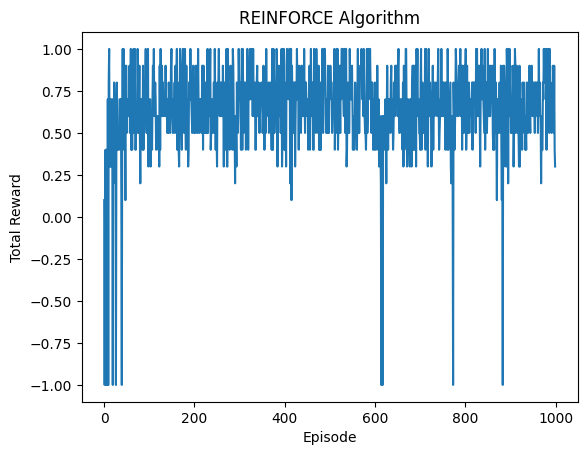

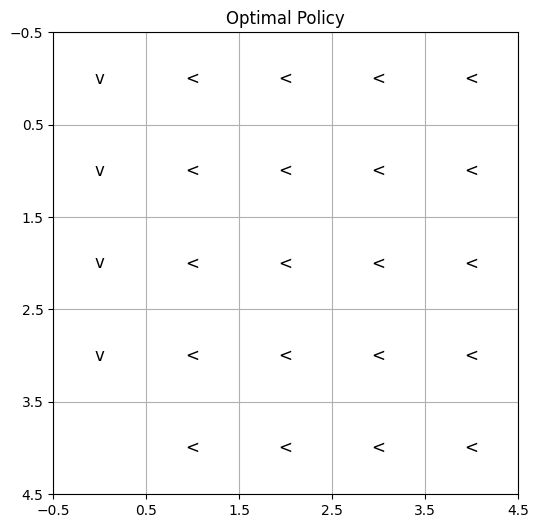

In [121]:
n = 5
env = GridEnvironment(n)
input_size = 2
hidden_size = 32
output_size = 4
policy_net = PolicyNetwork(input_size, hidden_size, output_size)
value_net = ValueNetwork(input_size, hidden_size, 1)  # ValueNetwork 추가
policy_optimizer = optim.Adam(policy_net.parameters(), lr=0.01)
value_optimizer = optim.Adam(value_net.parameters(), lr=0.01)  # ValueNetwork의 옵티마이저 추가

# REINFORCE 알고리즘 실행 with State value function
episode_rewards2 = reinforce_with_state_value(env, policy_net, value_net, policy_optimizer, value_optimizer, num_episodes=1000)

# 최적의 정책 계산
optimal_actions2 = optimal_policy(env, policy_net)

# 시각화
plot_rewards(episode_rewards2)
plot_optimal_path(optimal_actions2, n)

# Average Return

In [122]:
import torch
import numpy as np

# REINFORCE 알고리즘 with Average Return
def reinforce(env, policy_net, optimizer, num_episodes=1000):
    episode_rewards = []

    for episode in range(num_episodes):
        episode_reward = 0
        log_probs = []
        rewards = []

        state = torch.FloatTensor([env.agent_pos[0], env.agent_pos[1]])

        while True:
            action_probs = policy_net(state)
            action = torch.multinomial(action_probs, 1).item()
            log_probs.append(torch.log(action_probs[action]))

            next_state, reward, done = env.step(action)
            rewards.append(reward)
            episode_reward += reward

            if done:
                break

            state = torch.FloatTensor([next_state[0], next_state[1]])

        episode_rewards.append(episode_reward)

        # 정책 업데이트
        avg_return = np.mean(rewards)
        policy_loss = []
        for log_prob in log_probs:
            policy_loss.append(-log_prob * (avg_return - 0.1))  # Baseline을 0.1로 설정
        policy_loss = torch.stack(policy_loss).sum()

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        env.reset()

    return episode_rewards

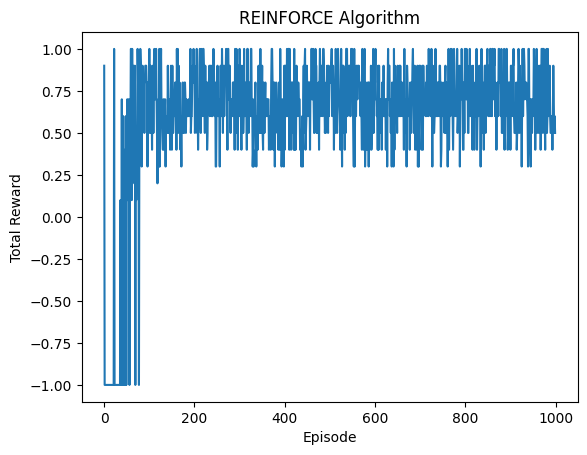

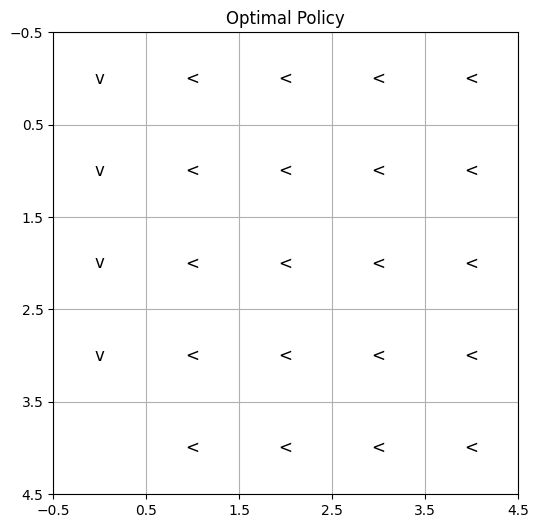

In [123]:
# 주어진 조건에 맞게 초기화
n = 5
env = GridEnvironment(n)
input_size = 2
hidden_size = 32
output_size = 4
policy_net = PolicyNetwork(input_size, hidden_size, output_size)
optimizer = optim.Adam(policy_net.parameters(), lr=0.01)

# REINFORCE 알고리즘 실행
episode_rewards3 = reinforce(env, policy_net, optimizer, num_episodes=1000)

# 최적의 정책 계산
optimal_actions3 = optimal_policy(env, policy_net)

# 시각화
plot_rewards(episode_rewards3)
plot_optimal_path(optimal_actions3, n)

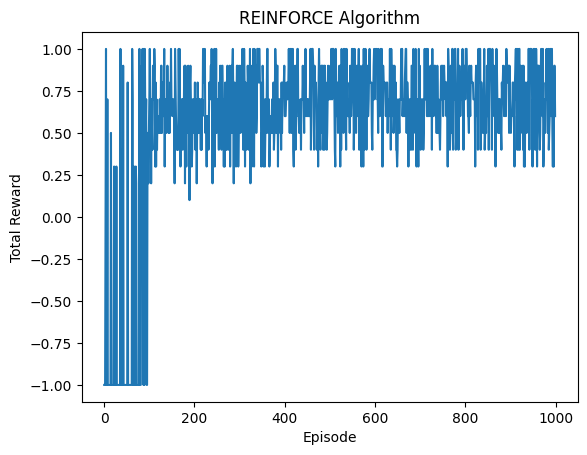

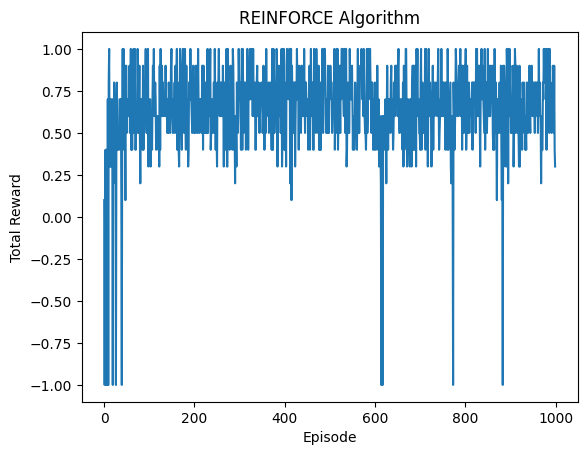

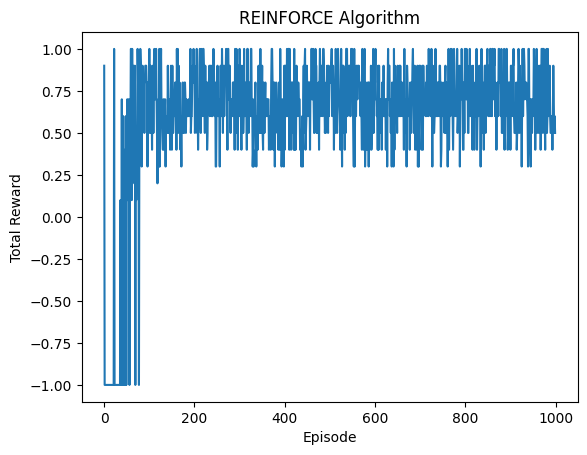

In [124]:
plot_rewards(episode_rewards1)
plot_rewards(episode_rewards2)
plot_rewards(episode_rewards3)

3가지 방법 모두 policy gradient가 다른 REINFORCE 알고리즘이다. </br>


*   일반적인 REINFORCE 알고리즘은 각 에피소드에서 얻는 총 리턴을 사용하여 보상을 계산합니다.
*   REINFORCE 알고리즘 with Average Return은 각 상태에서의 평균 리턴을 사용하여 보상을 계산합니다.
*   REINFORCE 알고리즘 with State value function은 어드밴티지 함수를 사용하여 보상을 계산합니다.


이는 상태의 가치 함수 추정값을 사용하여 얻습니다.
이러한 차이점에도 불구하고, 이 알고리즘들은 모두 비슷한 방식으로 정책을 학습하고 최적의 행동을 찾습니다. 따라서 이들 간에는 **큰 차이가 없을 수 있습니다.**

Baseline은 정책 그래디언트 알고리즘에서 분산을 줄이기 위해 사용됩니다. Baseline은 에피소드의 평균 리턴 또는 상태의 가치 함수 추정값과 같은 값으로 설정될 수 있습니다. 일반적으로 학습 중에 Baseline을 조정하며 최적의 값을 찾아야 합니다. 너무 높거나 낮은 Baseline 값은 학습을 방해할 수 있습니다. 일반적으로 0이나 에피소드의 평균 리턴과 같은 값이 일반적으로 사용되지만, 환경에 따라 적절한 Baseline 값을 선택해야 합니다. 따라서 올바른 Baseline 값은 환경과 알고리즘의 특성에 따라 다를 수 있습니다. 실험을 통해 최적의 Baseline 값을 찾는 것이 중요합니다.